In [1]:
from matplotlib import pyplot
import numpy as np 

import os 

from keras.models import load_model
import h5py
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers, callbacks, regularizers, initializers
from E2E_conv import *
from E2E_conv import *

batch_size = 14
dropout = 0.5
momentum = 0.9
noise_weight = 0.125
lr = 0.01
decay = 0.0005

# Setting l2_norm regularizer
reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

# In[48]:

# Model architecture 
behavdir = "/Users/nicolasfarrugia/Documents/recherche/git/Gold-MSI-LSD77/behav"

X = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['X']

n_feat = X.shape[1]

model = Sequential()
model.add(E2E_conv(2,32,(2,n_feat),kernel_regularizer=reg,input_shape=(n_feat,n_feat,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(E2E_conv(2,32,(2,n_feat),kernel_regularizer=reg,data_format="channels_last"))
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(64,(1,n_feat),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(256,(n_feat,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(128,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(30,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.add(LeakyReLU(alpha=0.33))
model.summary()

model.load_weights("BrainCNN-gmsi.h5")

Using TensorFlow backend.


kernel_shape : (2, 64, 1, 32)
data shape : (?, 64, 64, 1)
(1, 64, 1, 32)
(64, 1, 1, 32)
cat1(?, 64, 64, 32)
cat2<dtype: 'float32'>
First layer output shape :(None, 64, 64, 32)
kernel_shape : (2, 64, 32, 32)
data shape : (?, 64, 64, 32)
(1, 64, 32, 32)
(64, 1, 32, 32)
cat1(?, 64, 64, 32)
cat2<dtype: 'float32'>
(None, 64, 64, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 64, 64, 32)        4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
e2e_conv_2 (E2E_conv)        (None, 64, 64, 32)        131072    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (

In [2]:
y = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['y']
labels = np.load(os.path.join(behavdir,"X_y_lsd77_static_tangent.npz"))['labels']


print(labels[3],",",labels[4])

y=y[:,[3,4]]

GoldMSI_Active_sum , GoldMSI_Training_sum


(1, 64, 32, 64)
(1, 64, 32)
(64, 32)


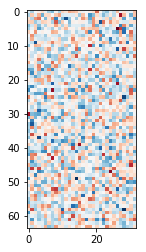

In [3]:
from matplotlib import pyplot as plt 

layer = model.layers[4]
weights = layer.get_weights()[0]
print(weights.shape)
from numpy.linalg import norm
image = norm(weights,axis = 3)
print(image.shape)
image = image.reshape(64,32)
print(image.shape)
plt.imshow(image,cmap='RdBu_r')
plt.show()

In [38]:
import numpy as np
from nilearn import datasets
from nilearn.plotting import find_xyz_cut_coords
from nilearn.image import math_img

basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale064']

import nibabel as nib 

nib_basc444 = nib.load(basc)
labels_data = nib_basc444.get_data()   

#fetch all possible label values 
all_labels = np.unique(labels_data)
# remove the 0. value which correspond to voxels out of ROIs
all_labels = all_labels[1:]


allcoords=[]
for i,curlabel in enumerate(all_labels):
    img_curlab = math_img(formula="img==%d"%curlabel,img=nib_basc444)
    allcoords.append(find_xyz_cut_coords(img_curlab))

In [4]:
#X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)

def symet(X):
    return 0.5*(X + X.T)

def iden(W):
    return W

In [5]:
from vis import input_modifiers as inpu

binarizer = inpu.InputModifier()

binarizer.post = symet
binarizer.pre = iden

In [31]:
### Here we define the Loss function to estimate ternary activations in a layer 

from vis.losses import Loss

class EstimateTernaryInput(Loss):
    """A loss function that estimates Ternary activations (+1,0,-1) of a set of filters within a particular layer.
    
    One might also use this to generate an input image that is easily interpretable wrt to outputs on the final
    `keras.layers.Dense` layer.
    """
    def __init__(self, img_input):
        """
        Args:
            layer: The keras layer whose filters need to be maximized. This can either be a convolutional layer
                or a dense layer.
            
        """
        #super(ActivationMaximization, self).__init__()
        self.name = "Ternary Activation"
        self.img = img_input
        #self.filter_indices = utils.listify(filter_indices)

    def build_loss(self):
        img = K.cast(self.img,'float32')
        
        img = K.reshape(img,(64,64))

        
        
        loss = 0.
        
        loss += K.sum(K.pow(img-1,2) * K.pow(img+1,2) * K.pow(img,2))
        
        #for row in img:
        #    for val in row:
        #        loss += (val - 1) * (val +1) * val
    

        return loss


In [73]:
from vis.regularizers import LPNorm,TotalVariation
from vis.losses import ActivationMaximization
from vis.utils import utils

from vis.visualization import visualize_activation_with_losses

def visualize_activation_ternary(model, layer_idx, filter_indices=None, wrt_tensor=None,
                         seed_input=None, input_range=(-1, 1),
                         backprop_modifier=None, grad_modifier=None,
                         act_max_weight=1, lp_norm_weight=10, tv_weight=10,alpha=1e-3,
                         **optimizer_params):
    """Generates the model input that maximizes the output of all `filter_indices` in the given `layer_idx`, and
    put it in ternary representation
    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
            If you are visualizing final `keras.layers.Dense` layer, consider switching 'softmax' activation for
            'linear' using [utils.apply_modifications](vis.utils.utils#apply_modifications) for better results.
        wrt_tensor: Short for, with respect to. The gradients of losses are computed with respect to this tensor.
            When None, this is assumed to be the same as `input_tensor` (Default value: None)
        seed_input: Seeds the optimization with a starting input. Initialized with a random value when set to None.
            (Default value = None)
        input_range: Specifies the input range as a `(min, max)` tuple. This is used to rescale the
            final optimized input to the given range. (Default value=(0, 255))
        backprop_modifier: backprop modifier to use. See [backprop_modifiers](vis.backprop_modifiers.md). If you don't
            specify anything, no backprop modification is applied. (Default value = None)
        grad_modifier: gradient modifier to use. See [grad_modifiers](vis.grad_modifiers.md). If you don't
            specify anything, gradients are unchanged (Default value = None)
        act_max_weight: The weight param for `ActivationMaximization` loss. Not used if 0 or None. (Default value = 1)
        lp_norm_weight: The weight param for `LPNorm` regularization loss. Not used if 0 or None. (Default value = 10)
        tv_weight: The weight param for `TotalVariation` regularization loss. Not used if 0 or None. (Default value = 10)
        alpha : regularization parameter for the ternarization
        optimizer_params: The **kwargs for optimizer [params](vis.optimizer#optimizerminimize). Will default to
            reasonable values when required keys are not found.
    Example:
        If you wanted to visualize the input image that would maximize the output index 22, say on
        final `keras.layers.Dense` layer, then, `filter_indices = [22]`, `layer_idx = dense_layer_idx`.
        If `filter_indices = [22, 23]`, then it should generate an input image that shows features of both classes.
    Returns:
        The model input that maximizes the output of `filter_indices` in the given `layer_idx`.
    """
    if backprop_modifier is not None:
        modifier_fn = get(backprop_modifier)
        model = modifier_fn(model)

    losses = [
        (ActivationMaximization(model.layers[layer_idx], filter_indices), act_max_weight),
        (LPNorm(model.input,1), lp_norm_weight),
        (TotalVariation(model.input), tv_weight),
        (EstimateTernaryInput(model.input), alpha)
    ]

    # Add grad_filter to optimizer_params.
    optimizer_params = utils.add_defaults_to_kwargs({
        'grad_modifier': grad_modifier
    }, **optimizer_params)

    return visualize_activation_with_losses(model.input, losses, wrt_tensor,
                                            seed_input, input_range, **optimizer_params)

In [82]:
heatmaptest = visualize_activation_ternary(model,verbose =0,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=0,
                                           act_max_weight=10, lp_norm_weight=0, tv_weight=0,alpha=1e-1,
                                           input_range = (-1.,1.))[:,:,0]


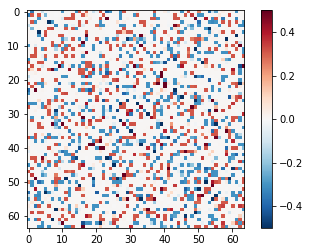

In [83]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(((heatmaptest)),interpolation='nearest',vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r)
plt.colorbar()


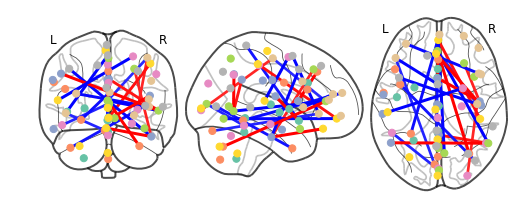

In [84]:
from nilearn.plotting import plot_connectome

plot_connectome((heatmaptest),allcoords,edge_threshold = '99%')


In [205]:
heatmaptest = visualize_activation(model,verbose =1,layer_idx=-1,input_modifiers=[binarizer],
                                   filter_indices=1,input_range = (-0.5,0.5))[:,:,0]

Iteration: 1, named_losses: <zip object at 0x155e6c388>, overall loss: 0.045310668647289276
Iteration: 2, named_losses: <zip object at 0x1560e4e88>, overall loss: 476.3644104003906
Iteration: 3, named_losses: <zip object at 0x155fe8948>, overall loss: 94.97010040283203
Iteration: 4, named_losses: <zip object at 0x155e6c388>, overall loss: 127.71703338623047
Iteration: 5, named_losses: <zip object at 0x155e86148>, overall loss: 67.62468719482422
Iteration: 6, named_losses: <zip object at 0x155fe8948>, overall loss: 87.34283447265625
Iteration: 7, named_losses: <zip object at 0x1560e4e88>, overall loss: 48.333675384521484
Iteration: 8, named_losses: <zip object at 0x155e86148>, overall loss: 68.96142578125
Iteration: 9, named_losses: <zip object at 0x155fe8948>, overall loss: 37.708492279052734
Iteration: 10, named_losses: <zip object at 0x1560e4e88>, overall loss: 59.45117950439453
Iteration: 11, named_losses: <zip object at 0x155e86148>, overall loss: 31.954862594604492
Iteration: 12, 

Iteration: 96, named_losses: <zip object at 0x155f2e648>, overall loss: 32.786041259765625
Iteration: 97, named_losses: <zip object at 0x155f22048>, overall loss: 9.195277214050293
Iteration: 98, named_losses: <zip object at 0x155fae108>, overall loss: 32.797420501708984
Iteration: 99, named_losses: <zip object at 0x155f2e648>, overall loss: 9.167356491088867
Iteration: 100, named_losses: <zip object at 0x155e6c388>, overall loss: 32.827640533447266
Iteration: 101, named_losses: <zip object at 0x155fae108>, overall loss: 9.149948120117188
Iteration: 102, named_losses: <zip object at 0x155f22048>, overall loss: 32.881736755371094
Iteration: 103, named_losses: <zip object at 0x155e6c388>, overall loss: 9.138138771057129
Iteration: 104, named_losses: <zip object at 0x155fae108>, overall loss: 32.944583892822266
Iteration: 105, named_losses: <zip object at 0x155f22048>, overall loss: 9.11967658996582
Iteration: 106, named_losses: <zip object at 0x155e6c388>, overall loss: 32.98346710205078

Iteration: 194, named_losses: <zip object at 0x155f22048>, overall loss: 34.247406005859375
Iteration: 195, named_losses: <zip object at 0x155e98f88>, overall loss: 8.416740417480469
Iteration: 196, named_losses: <zip object at 0x155fe8948>, overall loss: 34.27705001831055
Iteration: 197, named_losses: <zip object at 0x155f22048>, overall loss: 8.405214309692383
Iteration: 198, named_losses: <zip object at 0x156bbbfc8>, overall loss: 34.3214111328125
Iteration: 199, named_losses: <zip object at 0x155fe8948>, overall loss: 8.400735855102539
Iteration: 200, named_losses: <zip object at 0x155f22048>, overall loss: 34.3722038269043


array([[ 0.13644278, -0.00101299, -0.00192429, ..., -0.13989253,
        -0.14210962, -0.00260431],
       [-0.00101299,  0.13640827, -0.00087741, ..., -0.00272635,
        -0.00241616, -0.00210462],
       [-0.00192429, -0.00087741, -0.13999029, ..., -0.00270466,
        -0.13967789,  0.13618722],
       ..., 
       [-0.13989253, -0.00272635, -0.00270466, ...,  0.138114  ,
        -0.13917242, -0.14198785],
       [-0.14210962, -0.00241616, -0.13967789, ..., -0.13917242,
         0.13625856,  0.13463833],
       [-0.00260431, -0.00210462,  0.13618722, ..., -0.14198785,
         0.13463833,  0.13542392]])

In [47]:
heatmap1 = visualize_activation(model,layer_idx=-1, act_max_weight=0, lp_norm_weight=0, tv_weight=0,filter_indices=1,input_range = (-2.,2.))[:,:,0]
heatmap0 = visualize_activation(model,layer_idx=-1, act_max_weight=5, lp_norm_weight=0, tv_weight=0,filter_indices=0,input_range = (-2.,2.))[:,:,0]

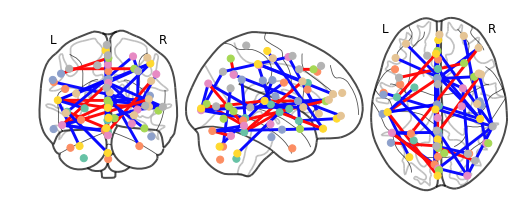

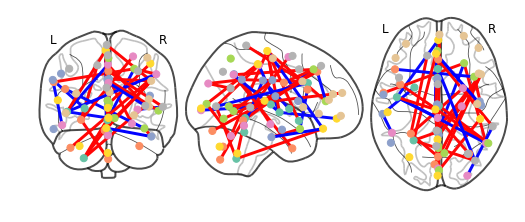

In [48]:
from nilearn.plotting import plot_connectome
%matplotlib inline 
plot_connectome(heatmap1.T+heatmap1,allcoords,edge_threshold = '98%')
plt.show()
plot_connectome(heatmap0.T+heatmap0,allcoords,edge_threshold = '98%')
plt.show()

Tests with SHAP 
--

Keras format :

In [3]:
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)


In [4]:
X.shape

(304, 64, 64, 1)

Here we take the Keras model trained above and explain why it makes different predictions for different individuals. SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.

In [5]:
def f(X):
    X = X.reshape(X.shape[0],64,64,1)
    return model.predict(X)

In [6]:
import shap
from shap import KernelExplainer, DenseData, visualize, initjs, Instance

# print the JS visualization code to the notebook
initjs()

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [73]:
featlabs = np.arange(1,64*64+1)
Xdata = DenseData(X_train[:50].reshape(50,64*64),featlabs)
explainer = KernelExplainer(f, Xdata,nsamples=500)

In [ ]:
e = explainer.explain(X_test.reshape(X_test.shape[0],64*64))